## Initialisation

### Dependencies

#### Third party

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression 
from scipy import optimize 
from IPython.display import Latex                                                                                                                                                                                                                                                                

#### Personal notebooks

In [8]:
import ipynb
from ipynb.fs.full.dataset_initialisation import (
    x,
    y,
    x_label,
    y_label,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    group_by,
)

### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress

## Plot of Engineering Strain v/s Engineering Stress

### Sanitise dataset and plot $e$ v/s $s$

1. Remove the values where $s < 0$.
2. Group multiple values of $s$ corresponding to the same value of $e$.

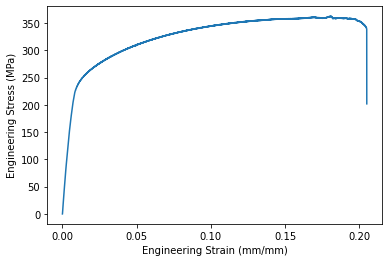

In [9]:
# Remove negative engineering stresses
item = len(x) - 1
delete = []
while item >=0:
  if y[item] < 0:
    delete.append(item)
  item -= 1

x.drop(delete)
y.drop(delete)

# Group duplicates
x, y = group_by(x, y)
plt.xlabel(x_label)
plt.ylabel(y_label)
_ = plt.plot(x,y)

### Reduce noise in the curve

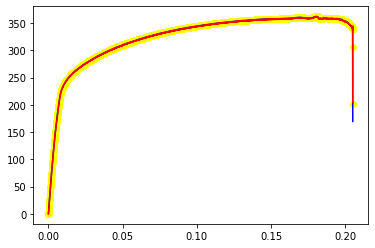

In [10]:
#coefs = np.polyfit(x, y, 10)
#y_polyfit = np.polyval(coefs, x)
#plt.plot(x, y_fit, color='blue')
#plt.scatter(x,y, color='yellow')
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
yhat = savgol_filter(y, 51, 11)
y_fit = smooth(y,19)
plt.scatter(x,y, color = 'yellow')
plt.plot (x, y_fit, color = 'blue')
plt.plot(x, yhat, color = 'red')
test_x = np.log(x[1:])
test_y = np.log(y[1:])
#plt.plot(test_x,test_y)
#print ('logx:', test_x)
#print ('logy:', test_y)
# print ('x:', x)
# print ('y:', y)
# print ('y_hat:', yhat)
# print ('y_fit:', y_fit)
# print('diff:',diff[2])

## Calculation of Young's modulus ($E$)

Young's Modulus: 23.290674900073682 GPa
Minimum chi squared: -95911.95664908217


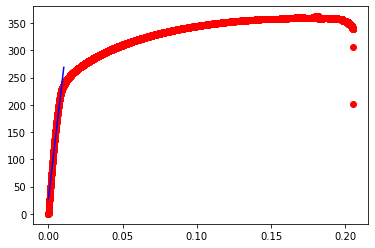

In [11]:
num_points = 900

min_fit_length = 601

chi = 0

chi_min = 10000

i_best = 0
j_best = 0

for i in range(len(x[:num_points]) - min_fit_length):
  for j in range(i+min_fit_length, len(x[:num_points])):
    start = i
    end = j
    # print(x[i:j], y[i:j])
    coefs = np.polyfit(x[i:j],y[i:j],1)
    y_linear = [i*coefs[0] + coefs[1] for i in x[start:end]]
    chi = 0
    for k in range(i,j):
      chi += ((y_linear[k-start] - y[k])**2)/y[k]

    if chi < chi_min:
      i_best = i
      j_best = j
      chi_min = chi

coefs = np.polyfit(x[i_best:j_best],y[i_best:j_best],1)
y_linear = [i*coefs[0] + coefs[1] for i in x[i_best:j_best]]

youngs_modulus = (y_linear[1] - y_linear[0])/(x[i_best+1] - x[i_best])
print(f'Young\'s Modulus: {youngs_modulus/1000} GPa')
print(f'Minimum chi squared: {chi_min}')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y,'ro')
ax.plot(x[i_best:j_best],y_linear,'b-')
plt.show()

For degree of freedom `600`, the critical $ \chi^2 $ value for `5%` is `658.094`. So as long as the chi squared value is below the critical value, the fit cannot be rejected.

Source: https://www.medcalc.org/manual/chi-square-table.php

## Calculation of Yield strength ($\sigma_{ys}$)

Yield Strength: 246.24515 MPa


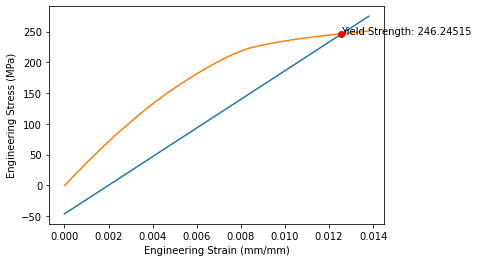

In [12]:
required_points = 1200
parallel_line_y = [(i - 0.002)*youngs_modulus for i in x[:required_points]]
plt.plot(x[:required_points], parallel_line_y)
plt.plot(x[:required_points],y[:required_points])
intersection = np.argwhere(np.diff(np.sign([parallel_line_y[i] - y[i] for i in range(required_points)]))).flatten()
plt.plot(x[intersection[0]], y[intersection[0]], 'ro')
plt.xlabel(x_label)
plt.ylabel(y_label)
yield_strength = y[intersection[0]]
plt.annotate(f'Yield Strength: {yield_strength}', (x[intersection[0]], y[intersection[0]]))
# 0th index because there is only one intersection point
print(f'Yield Strength: {yield_strength} MPa')

## Calculation of Ultimate tensile strength ($\sigma_{uts}$)

Ultimate Tensile Strength is 362.27072 MPa at 18.095% elongation.


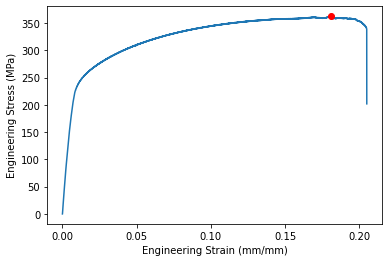

In [13]:
# Fetch the max value of the engineering stress from the dataset.
uts_abscissa = 0
uts = y[uts_abscissa]
for i in range(0,len(y)):
    if y[i] >= uts:
        uts = y[i]
        uts_abscissa = i
uts_strain = x[uts_abscissa]
plt.plot(x,y)
plt.plot(uts_strain, uts, 'ro')
plt.xlabel(x_label)
plt.ylabel(y_label)
print(f'Ultimate Tensile Strength is {uts} MPa at {uts_strain*100}% elongation.')

### Plastic Region

In [ ]:
plt.plot(x[intersection[0]], y[intersection[0]], 'ro') # YS
plt.plot(uts_strain, uts, 'ro') # UTS
# there is only one intersection point
start = intersection[0]
end = uts_abscissa+1
plt.plot(x[start:end], y[start:end])
# supresses ouput while setting x,y labels
_ = plt.xlabel(x_label)
_ = plt.ylabel(y_label)